In [3]:
from collections import Counter, defaultdict
from functools import partial, reduce
from linear_algebra import shape, get_row, get_column, make_matrix, \
    vector_mean, vector_sum, dot, magnitude, vector_subtract, scalar_multiply
from stats import correlation, standard_deviation, mean
from probability import inverse_normal_cdf
from gradient_descent import maximize_batch
import math, random, csv
import matplotlib.pyplot as plt
import dateutil.parser

In [4]:
def bucketize(point, bucket_size):
    """floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    """buckets the points and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()

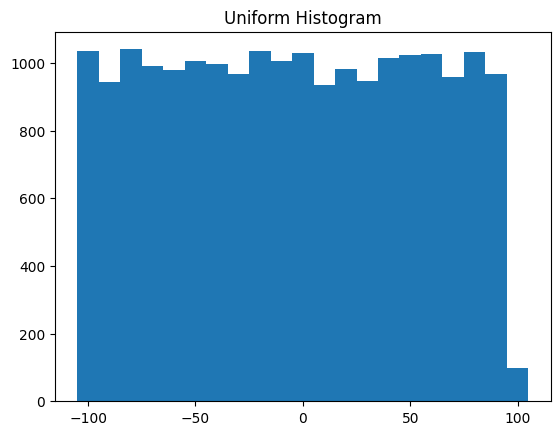

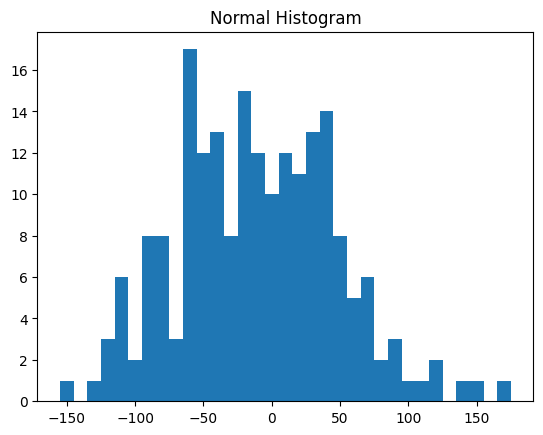

In [8]:
def compare_two_distributions():

    random.seed(0)

    uniform = [random.randrange(-100,101) for _ in range(20000)]
    normal = [57 * inverse_normal_cdf(random.random())
              for _ in range(200)]

    plot_histogram(uniform, 10, "Uniform Histogram")
    plot_histogram(normal, 10, "Normal Histogram")

compare_two_distributions()

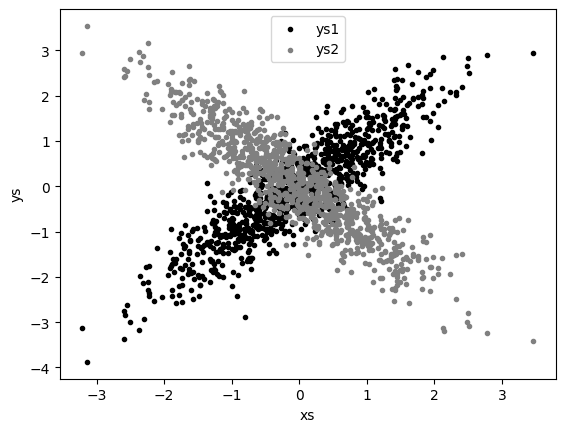

correlation(xs, ys1) 0.889346697340968
correlation(xs, ys2) -0.9059367927286904


In [12]:
def random_normal():
    """returns a random draw from a standard normal distribution"""
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

def scatter():
    plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
    plt.scatter(xs, ys2, marker='.', color='gray',  label='ys2')
    plt.xlabel('xs')
    plt.ylabel('ys')
    plt.legend(loc=9)
    plt.show()

scatter()

print("correlation(xs, ys1)", correlation(xs, ys1))
print("correlation(xs, ys2)", correlation(xs, ys2))

In [13]:
def correlation_matrix(data):
    """returns the num_columns x num_columns matrix whose (i, j)th entry
    is the correlation between columns i and j of data"""

    _, num_columns = shape(data)

    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))

    return make_matrix(num_columns, num_columns, matrix_entry)

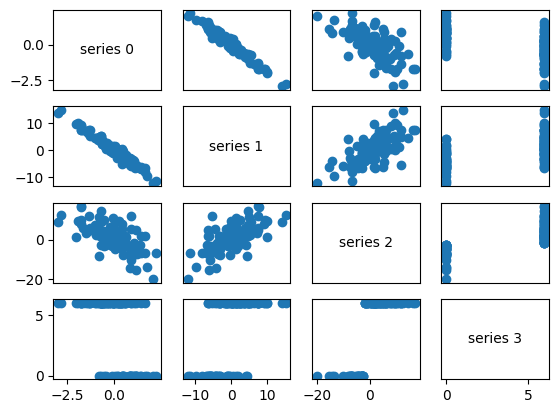

In [14]:
def make_scatterplot_matrix():

    # first, generate some random data

    num_points = 100

    def random_row():
        row = [None, None, None, None]
        row[0] = random_normal()
        row[1] = -5 * row[0] + random_normal()
        row[2] = row[0] + row[1] + 5 * random_normal()
        row[3] = 6 if row[2] > -2 else 0
        return row
    random.seed(0)
    data = [random_row()
            for _ in range(num_points)]

    # then plot it

    _, num_columns = shape(data)
    fig, ax = plt.subplots(num_columns, num_columns)

    for i in range(num_columns):
        for j in range(num_columns):

            # scatter column_j on the x-axis vs column_i on the y-axis
            if i != j: ax[i][j].scatter(get_column(data, j), get_column(data, i))

            # unless i == j, in which case show the series name
            else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                    xycoords='axes fraction',
                                    ha="center", va="center")

            # then hide axis labels except left and bottom charts
            if i < num_columns - 1: ax[i][j].xaxis.set_visible(False)
            if j > 0: ax[i][j].yaxis.set_visible(False)

    # fix the bottom right and top left axis labels, which are wrong because
    # their charts only have text in them
    ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
    ax[0][0].set_ylim(ax[0][1].get_ylim())

    plt.show()

make_scatterplot_matrix()

In [15]:
def parse_row(input_row, parsers):
    """given a list of parsers (some of which may be None)
    apply the appropriate one to each element of the input_row"""
    return [parser(value) if parser is not None else value
            for value, parser in zip(input_row, parsers)]

def parse_rows_with(reader, parsers):
    """wrap a reader to apply the parsers to each of its rows"""
    for row in reader:
        yield parse_row(row, parsers)

def try_or_none(f):
    """wraps f to return None if f raises an exception
    assumes f takes only one input"""
    def f_or_none(x):
        try: return f(x)
        except: return None
    return f_or_none

def parse_row(input_row, parsers):
    return [try_or_none(parser)(value) if parser is not None else value
            for value, parser in zip(input_row, parsers)]

def try_parse_field(field_name, value, parser_dict):
    """try to parse value using the appropriate function from parser_dict"""
    parser = parser_dict.get(field_name) # None if no such entry
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value

def parse_dict(input_dict, parser_dict):
    return { field_name : try_parse_field(field_name, value, parser_dict)
             for field_name, value in input_dict.items() }

In [16]:
data = []

with open("comma_delimited_stock_prices.csv", "r", encoding='utf8', newline='') as f:
    reader = csv.reader(f)
    for line in parse_rows_with(reader, [dateutil.parser.parse, None, float]):
        data.append(line)

for row in data:
    if any(x is None for x in row):
        print(row)

[datetime.datetime(2014, 6, 19, 0, 0), 'MSFT', None]


In [17]:
print("stocks")
with open("stocks.txt", "r", encoding='utf8', newline='') as f:
    reader = csv.DictReader(f, delimiter="\t")
    data = [parse_dict(row, { 'date' : dateutil.parser.parse,
                                'closing_price' : float })
            for row in reader]

max_aapl_price = max(row["closing_price"]
                        for row in data
                        if row["symbol"] == "AAPL")
print("max aapl price", max_aapl_price)

stocks
max aapl price 119.0


In [18]:
# group rows by symbol
by_symbol = defaultdict(list)

for row in data:
    by_symbol[row["symbol"]].append(row)

In [19]:
# use a dict comprehension to find the max for each symbol
max_price_by_symbol = { symbol : max(row["closing_price"]
                        for row in grouped_rows)
                        for symbol, grouped_rows in by_symbol.items() }
print("max price by symbol")
print(max_price_by_symbol)

max price by symbol
{'AAPL': 119.0, 'MSFT': 49.3, 'FB': 81.45}


In [21]:
def picker(field_name):
    """returns a function that picks a field out of a dict"""
    return lambda row: row[field_name]

def pluck(field_name, rows):
    """turn a list of dicts into the list of field_name values"""
    return map(picker(field_name), rows)

def group_by(grouper, rows, value_transform=None):
    # key is output of grouper, value is list of rows
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
    if value_transform is None:
        return grouped
    else:
        return { key : value_transform(rows)
                 for key, rows in grouped.items() }

def percent_price_change(yesterday, today):
    return today["closing_price"] / yesterday["closing_price"] - 1

def day_over_day_changes(grouped_rows):
    # sort the rows by date
    ordered = sorted(grouped_rows, key=picker("date"))
    # zip with an offset to get pairs of consecutive days
    return [{ "symbol" : today["symbol"],
              "date" : today["date"],
              "change" : percent_price_change(yesterday, today) }
             for yesterday, today in zip(ordered, ordered[1:])]

In [22]:
def scale(data_matrix):
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix,j))
             for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix,j))
              for j in range(num_cols)]
    return means, stdevs

def rescale(data_matrix):
    """rescales the input data so that each column
    has mean 0 and standard deviation 1
    ignores columns with no deviation"""
    means, stdevs = scale(data_matrix)

    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]

    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)

In [23]:
# key is symbol, value is list of "change" dicts
changes_by_symbol = group_by(picker("symbol"), data, day_over_day_changes)
# collect all "change" dicts into one big list
all_changes = [change
                for changes in changes_by_symbol.values()
                for change in changes]

print("max change", max(all_changes, key=picker("change")))
print("min change", min(all_changes, key=picker("change")))

# to combine percent changes, we add 1 to each, multiply them, and subtract 1
# for instance, if we combine +10% and -20%, the overall change is
# (1 + 10%) * (1 - 20%) - 1 = 1.1 * .8 - 1 = -12%
def combine_pct_changes(pct_change1, pct_change2):
    return (1 + pct_change1) * (1 + pct_change2) - 1

def overall_change(changes):
    return reduce(combine_pct_changes, pluck("change", changes))

overall_change_by_month = group_by(lambda row: row['date'].month,
                                    all_changes,
                                    overall_change)
print("overall change by month")
print(overall_change_by_month)

print("rescaling")

data = [[1, 20, 2],
        [1, 30, 3],
        [1, 40, 4]]

print("original: ", data)
print("scale: ", scale(data))
print("rescaled: ", rescale(data))
print()

print("PCA")

Y = de_mean_matrix(X)
components = principal_component_analysis(Y, 2)
print("principal components", components)
print("first point", Y[0])
print("first point transformed", transform_vector(Y[0], components))

max change {'symbol': 'AAPL', 'date': datetime.datetime(1997, 8, 6, 0, 0), 'change': 0.3283582089552237}
min change {'symbol': 'AAPL', 'date': datetime.datetime(2000, 9, 29, 0, 0), 'change': -0.5193370165745856}
overall change by month
{12: 2.2895332950255933, 1: 19.972214514609085, 2: 0.11858483359215, 3: 2.818850048603327, 4: 6.9341967849847626, 5: 1.2555660890321603, 6: -0.5977889232201744, 7: -0.17183091713561482, 8: 6.220055959879489, 9: -0.741162543642831, 10: 21.552541251680015, 11: 3.758572336791725}
rescaling
original:  [[1, 20, 2], [1, 30, 3], [1, 40, 4]]
scale:  ([1.0, 30.0, 3.0], [0.0, 10.0, 1.0])
rescaled:  [[1, -1.0, -1.0], [1, 0.0, 0.0], [1, 1.0, 1.0]]

PCA


NameError: name 'de_mean_matrix' is not defined